In [2]:
# IV for a single dot

import numpy as np
import imp
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.expanduser('~/quantum-ml/nanowire_model'))

import potential_profile
import markov
imp.reload(markov)
import thomas_fermi
imp.reload(thomas_fermi)
import tunneling
imp.reload(tunneling)
import exceptions

def get_dot_current_and_charge(physics_model,graph_model,tf_strategy):
    
    try:
        graph = markov.Markov(graph_model,physics_model,tf_strategy)
        graph.generate_graph()

        current = graph.get_current()
        charge_state = graph.get_charge_state()[0]

        del graph
    except exceptions.InvalidChargeState:
        current = 0
        # no dot
        charge_state = 0
    
    return current,charge_state


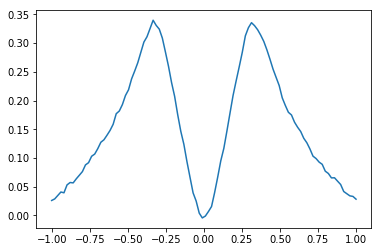

In [187]:
# physical parameters
E_scale = 'eV'
dx_scale = '1e-9'

kT = 400e-6
b1 = (-200e-3,-0.31,0.1,1)
d = (200e-3,0.0,0.1,1)
b2 = (-200e-3,0.31,0.1,1)

x = np.linspace(-1,1,100)
V = potential_profile.V_x_wire(x,[b1,d,b2])

K_onsite = 5e-3
sigma = x[1] - x[0]
x_0 = (x[1] - x[0])
mu_l = (100.0e-3,100.1e-3)
battery_weight = 100

physics_model = (E_scale,dx_scale,kT,x,V,K_onsite,sigma,x_0,mu_l,battery_weight)

# graph parameters
graph_model = (1,1)

tf_strategy = 'simple'

# white noise
V_peak_noise =10000e-6
V_noise = V_peak_noise*np.random.rand(len(x))


#plt.plot(V_spec)
plt.plot(x,V + V_noise)

In [7]:
import time
st = time.time()

# initial params
# physical parameters

b1 = (-200e-3,-0.30,0.1,1)
b2 = (-200e-3,0.30,0.1,1)

K_onsite = 5e-3
# number of random samples to use
N_samples = 1000
sigma_mu = 0.05

def create_dist(mean,sigma_mu,N_samples):
    '''
    Draw samples from a normal_dist with sigma/mu ratio.
    '''
    return np.random.normal(loc=mean,scale=sigma_mu*np.abs(mean),size=N_samples)

create_dist_fixed_sigma_mu = lambda x : create_dist(x,sigma_mu,N_samples)
K_onsite_dist = create_dist_fixed_sigma_mu(K_onsite)
b1_mu_dist = create_dist_fixed_sigma_mu(b1[1])
b2_mu_dist = create_dist_fixed_sigma_mu(b2[1])
b1_h_dist = create_dist_fixed_sigma_mu(b1[2])
b2_h_dist = create_dist_fixed_sigma_mu(b2[2])

# number of samples in the voltage grid

N_v = 100
V_d_vec = np.linspace(250e-3,300e-3,N_v)

I_vec = np.zeros((N_samples,N_v))
charge_state_vec = np.zeros((N_samples,N_v))
V_grid_vec = np.zeros((N_samples,N_v))
physics_model_vec = []
for i in range(N_samples):
    # physical parameters
    E_scale = 'eV'
    dx_scale = '1e-9'

    # draw physical params from the random sample
    kT = 1000e-6
    b1 = (-200e-3,b1_mu_dist[i],b1_h_dist[i],1)
    b2 = (-200e-3,b2_mu_dist[i],b2_h_dist[i],1)
    
    x = np.linspace(-1,1,25)

    K_onsite = K_onsite_dist[i]
    sigma = x[1] - x[0]
    x_0 = (x[1] - x[0])
    mu_l = (100.0e-3,100.1e-3)
    battery_weight = 1000

    # graph parameters
    graph_model = (15,1)

    tf_strategy = 'simple'
    
    for j in range(len(V_d_vec)):
        
        d = (V_d_vec[j],0.0,0.1,1)
        V = potential_profile.V_x_wire(x,[b1,d,b2])
        
        
        # white noise
        V_peak_noise =1e-3
        V_noise = V_peak_noise*np.random.rand(len(x))
    
        V = V + V_noise
        physics_model = (E_scale,dx_scale,kT,x,V,K_onsite,sigma,x_0,mu_l,battery_weight)
        physics_model_vec += [physics_model]
        
        I,charge_state = get_dot_current_and_charge(physics_model,graph_model,tf_strategy)
        I_vec[i,j] = I
        charge_state_vec[i,j] = charge_state
    if (i % (N_samples/10) == 0):
        print("Sample number:",i)
print("Completed in ",time.time()-st,"seconds.")

Sample number: 0
Sample number: 100
Sample number: 200
Sample number: 300
Sample number: 400
Sample number: 500


LinAlgError: SVD did not converge

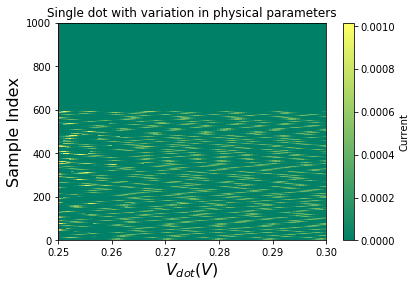

In [8]:
XX,YY = np.meshgrid(V_d_vec,np.arange(N_samples))
plt.pcolor(XX,YY,I_vec,cmap="summer")
cbar = plt.colorbar()
plt.xlabel(r'$V_{dot} (V)$',fontsize=16)
plt.ylabel('Sample Index',fontsize=16)
cbar.set_label('Current')
plt.title('Single dot with variation in physical parameters')


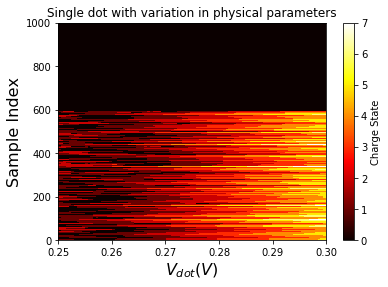

In [9]:
XX,YY = np.meshgrid(V_d_vec,np.arange(N_samples))
plt.pcolor(XX,YY,charge_state_vec,cmap="hot")
cbar = plt.colorbar()
plt.xlabel(r'$V_{dot} (V)$',fontsize=16)
plt.ylabel('Sample Index',fontsize=16)
cbar.set_label('Charge State')
plt.title('Single dot with variation in physical parameters')

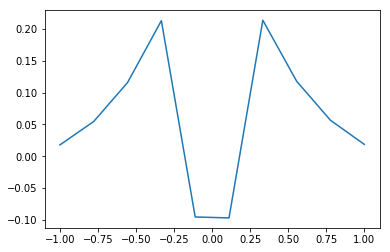

In [226]:
plt.plot(x,V)


In [103]:
print(charge_state_vec)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
   4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
   5.  5.  5.  5.  6.  6.  6.  6.  6.  6.]]


In [130]:
print(b1_h_dist)

[ 0.0992735]


In [132]:
print(K_onsite)

0.0051957274247


In [131]:
print(b2_h_dist)

[ 0.10705561]


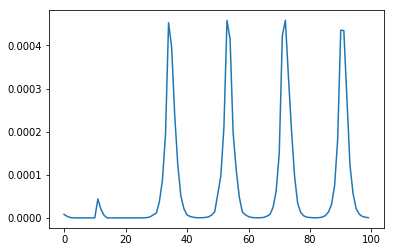

In [13]:
plt.plot(I_vec[9])


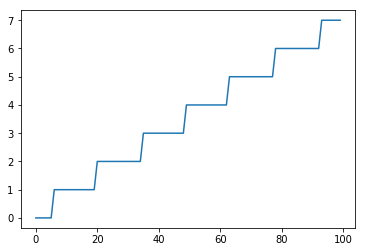

In [228]:
plt.plot(charge_state_vec[0])


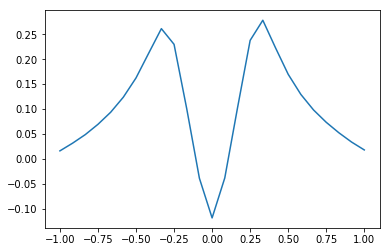

In [14]:
plt.plot(x,V)

In [40]:
data = []
for i in range(500):
    K_onsite = K_onsite_dist[i]
    b1_mu = b1_mu_dist[i]
    b2_mu = b2_mu_dist[i]
    b1_h = b1_h_dist[i]
    b2_h = b2_h_dist[i]
    data += [{'K_onsite' : K_onsite,'b1_mu' : b1_mu,'b2_mu' : b2_mu, 'b1_h' : b1_h, 'b2_h' : b2_h,\
              'I' : I_vec[i],'CS' : charge_state_vec[i].astype('int')}]
    

In [42]:
np.save('/Users/sandesh/quantum-ml/data/random_K_b_mu_h.npy',data)

In [43]:
d = np.load('/Users/sandesh/quantum-ml/data/random_K_b_mu_h.npy')

In [45]:
len(d)

500

In [46]:
d[23]

{'CS': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4]),
 'I': array([  1.23285424e-05,   4.24349187e-06,   1.78393179e-06,
          4.87359532e-07,   2.54086560e-07,   8.39604513e-08,
          2.27118758e-08,   1.06975290e-08,   3.52707154e-09,
          3.72440239e-09,   8.23007091e-09,   4.07485246e-05,
          1.02166444e-05,   5.42397479e-12,   9.29351237e-12,
          3.28298114e-11,   6.84135619e-11,   1.77331137e-10,
          1.97803190e-10,   6.91875803e-10,   1.46697863e-09,
          3.74237470e-09,   9.79169286e-09,   2.75119222e-08,
          6.66565050e-08,   1.83046062e-07,   4.28371682e-07,
          1.11671263e-06,   2.95627900e-06,   1.07476204e-05,
          2.11750156e-05,  

In [47]:
d[36]

{'CS': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6]),
 'I': array([  4.27241420e-07,   5.13747054e-07,   1.13582415e-06,
          2.74996623e-06,   5.57626117e-06,   2.43783805e-05,
          4.33711985e-05,   2.07456004e-04,   3.83627437e-04,
          4.54320099e-04,   3.60979853e-04,   2.25550042e-04,
          1.14362368e-04,   3.75225265e-05,   1.73052315e-05,
          4.75009895e-06,   2.04630092e-06,   1.13787167e-06,
          4.63340745e-07,   4.36282095e-07,   1.04641572e-06,
          1.96640983e-06,   4.84891383e-06,   1.30849162e-05,
          2.75661553e-05,   1.31864753e-04,   2.95388154e-04,
          4.23981041e-04,   4.43307263e-04,   3.19400392e-04,
          1.30870892e-04,  